In [111]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense,BatchNormalization,Conv2D, Conv1D
from keras.layers import Input,GlobalMaxPooling2D,concatenate, GlobalMaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from os import listdir, getcwd, chdir
from os.path import isfile, join

In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/nancelab/diff_predictor


In [3]:
data_path = '../diff_predictor/raw_data_pnn/'
filelist = [f for f in listdir(data_path) if isfile(join(data_path, f)) and '' in f]
len(filelist) #Check to make sure there are the right number of files, in this case 180 - 60 per class

180

In [8]:
filelist[0]

'msd_HYase_brain_2_slice_3_vid_4.csv'

In [4]:
label = np.zeros([64,1])
label.shape

(64, 1)

In [5]:
out = np.zeros([64,100-1,1])
out.shape

(64, 99, 1)

In [6]:
partition = {
    'train': df['Track_ID'].unique()
}

NameError: name 'df' is not defined

In [6]:
df

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss,Quality,SN_Ratio,Mean_Intensity
0,0,0.0,0.0,143.975957,1666.191059,0.000000,0.000000,6.404266,0.860123,423.410853
1,1,1.0,0.0,143.986696,1665.273117,32.486171,0.969994,5.993530,0.733718,417.085271
2,2,2.0,0.0,137.519711,1664.689652,59.047953,0.548953,7.272522,0.771280,425.503876
3,3,3.0,0.0,138.059675,1664.788500,53.342281,0.652197,7.529022,0.949320,426.705426
4,4,4.0,0.0,134.721297,1667.048435,29.955698,0.985126,7.815430,0.933738,431.596899
...,...,...,...,...,...,...,...,...,...,...
2339689,279274,646.0,3593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339690,279275,647.0,3593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339691,279276,648.0,3593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2339692,279277,649.0,3593.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:

df = pd.read_csv(data_path+filelist[0])

track_ids = []
labels = dict()
#dataset = dict()

for track_id in df['Track_ID'].unique():
    labels[str(track_id)] = 0
    track_ids.append(str(track_id))
    track_data = df[df['Track_ID']==track_id][['X', 'Y']]
    #dataset[str(track_id)] = np.array(track_data)
    test_array = np.array(track_data)
    np.save(str(f'data/cnn_data/{filelist[0]}').replace(".csv", f"_traj_{int(track_id)}"), test_array)

partition = {
    'train': track_ids
}
   

In [81]:
test_array

(651, 2)

In [10]:
dataset[track_ids[0]]

array([[ 143.97595688, 1666.19105945],
       [ 143.98669615, 1665.27311675],
       [ 137.51971108, 1664.68965163],
       ...,
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan]])

In [105]:
class MptDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_path, list_IDs, labels, batch_size=32, dim=(651,2), n_channels=None,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))#, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            out_array = np.load(self.data_path + ID[:-2] + '.npy')
            X[i,] = out_array

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [106]:
training_generator = MptDataGenerator('../diff_predictor/data/cnn_data/msd_HYase_brain_2_slice_3_vid_4_traj_', partition['train'], labels)

In [107]:
inputs = Input((651, 2))
initializer = 'random_normal'
f = 32

In [114]:
model = Sequential()
model.add(Flatten())
model.add(Dense(512, input_dim=inputs, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# con = concatenate([x1,x2,x3,x4])
# dense = Dense(512,activation='relu')(con)
# dense = Dense(256,activation='relu')(dense)
# dense2 = Dense(1,activation='sigmoid')(dense)
# model = Model(inputs=inputs, outputs=dense2)

# optimizer = Adam(lr=1e-5)
# model.compile(optimizer=optimizer,loss='mse',metrics=['mse'])


In [115]:
model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['mean_squared_error'])

model.fit(training_generator, epochs=2, validation_data=training_generator)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
112/112 [==============================] - ETA: 0s - loss: nan - mean_squared_error: nanWARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc7a2e8e3b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attac

In [36]:
from sklearn.preprocessing import scale
output = scale()
output

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass copy=[[1391.73667658  957.40513897]
 [1385.86589585  960.40309034]
 [1388.45653238  960.29137335]
 ...
 [          nan           nan]
 [          nan           nan]
 [          nan           nan]] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


StandardScaler(copy=array([[1391.73667658,  957.40513897],
       [1385.86589585,  960.40309034],
       [1388.45653238,  960.29137335],
       ...,
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan]]))

In [55]:
x_y = np.array(df[df['Track_ID']== 1][['X', 'Y']])
x_y

array([[ 267.32757102, 1641.40302581],
       [ 268.89339992, 1641.86021464],
       [ 270.08193873, 1642.08710289],
       ...,
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan]])

In [ ]:
norm = np.linalg.norm(x_y, 1)
im = x_y/norm
plt.figure(figsize=(10,500))
plt.imshow(im)

In [66]:
x_y[:2,:]

array([[ 267.32757102, 1641.40302581],
       [ 268.89339992, 1641.86021464]])

In [75]:
def scale_array(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

output = scale_array(x_y[:19,:])
output

array([[0.        , 0.99881681],
       [0.0011382 , 0.99914914],
       [0.00200215, 0.99931406],
       [0.00186857, 0.99857293],
       [0.00198115, 0.99877591],
       [0.00222902, 1.        ],
       [0.00208032, 0.99915327],
       [0.00174777, 0.99917532],
       [0.00142778, 0.99879495],
       [0.00183042, 0.99753842],
       [0.00223305, 0.99628188],
       [0.00263569, 0.99502534],
       [0.00303833, 0.99376881],
       [0.00344097, 0.99251227],
       [0.00384361, 0.99125574],
       [0.00424624, 0.9899992 ],
       [0.00464888, 0.98874266],
       [0.0044428 , 0.98914569],
       [0.0051891 , 0.98822241]])

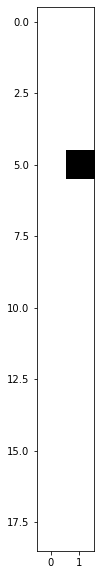

In [77]:
import cv2
%matplotlib inline
im = np.array(output).astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='Greys')
# grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
# cv2.imshow(mat=grayImage)

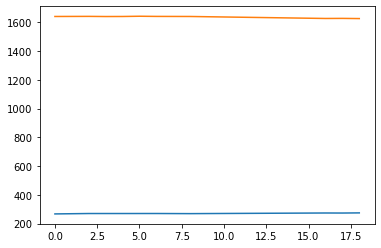

In [109]:
plt.plot(x_y)

In [64]:
def traj_generator(batch_size, datapath):
    out = np.zeros([batch_size, 651, 2]) #initialize trajectory array
    label = np.zeros([batch_size, 1]) #initialize label array
    batch_count = 0
    while True:
        df = pd.read_csv(datapath)
        for i in range(batch_size):
            batch_count += 1
            x_y = np.array(df[df['Track_ID']==i][['X', 'Y']])
            out[i,:,:] = x_y
            label[i] = 1
        yield out, label


In [13]:
inputs = Input((651, 2))
initializer = 'random_normal'
f = 32

In [43]:
x1 = Conv1D(f,4,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv1D(f,4,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = BatchNormalization()(x1)
x1 = Conv1D(f,4,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x1)
x1 = BatchNormalization()(x1)
x1 = GlobalMaxPooling1D()(x1)


x2 = Conv1D(f,2,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x2 = BatchNormalization()(x2)
x2 = Conv1D(f,2,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = BatchNormalization()(x2)
x2 = Conv1D(f,2,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x2)
x2 = BatchNormalization()(x2)
x2 = GlobalMaxPooling1D()(x2)


x3 = Conv1D(f,3,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x3 = BatchNormalization()(x3)
x3 = Conv1D(f,3,dilation_rate=2,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = BatchNormalization()(x3)
x3 = Conv1D(f,3,dilation_rate=4,padding='causal',activation='relu',kernel_initializer=initializer)(x3)
x3 = BatchNormalization()(x3)
x3 = GlobalMaxPooling1D()(x3)


x4 = Conv1D(f,10,padding='causal',activation='relu',kernel_initializer=initializer)(inputs)
x4 = BatchNormalization()(x4)
x4 = Conv1D(f,10,dilation_rate=5,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = BatchNormalization()(x4)
x4 = Conv1D(f,10,dilation_rate=10,padding='causal',activation='relu',kernel_initializer=initializer)(x4)
x4 = BatchNormalization()(x4)
x4 = GlobalMaxPooling1D()(x4)

con = concatenate([x1,x2,x3,x4])
dense = Dense(512,activation='relu')(con)
dense = Dense(256,activation='relu')(dense)
dense2 = Dense(1,activation='sigmoid')(dense)
model = Model(inputs=inputs, outputs=dense2)

optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='mse',metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 651, 2)]     0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 651, 32)      288         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 651, 32)      160         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 651, 32)      224         input_2[0][0]                    
____________________________________________________________________________________________

In [10]:
model = Sequential()
model.add(Dense(16, input_dim=1, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

In [15]:
model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['mean_squared_error'])

In [18]:
model.compile(loss='mean_absolute_error',
              optimizer=Adam(),
              metrics=['mean_squared_error'])

model.fit(training_generator, epochs=2, validation_data=training_generator)

TypeError: load() missing 1 required positional argument: 'file'